# Distance Estimation and Angle Recovery

TODO: put equateions

## Content

1. [Data Preparation](Read-Data)
2. 

## Read Data

Data used:
- Protein: 5j0n (symmetric protein)
- Projections: 5K
- Coverage: Half-sphere

![](figures/5j0n.pdb1-500.jpg)

In [1]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [2]:
import os
import h5py
import numpy as np
import time

import sys
sys.path.append("../..") 
from cryoem.plots import plot_angles_count
from IPython.display import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from cryoem.conversions import d_q, euler2quaternion
from cryoem.distance_estimation import train_siamese
import ipyvolume as ipv

In [3]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6138956576004083626
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6561730430364843028
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12348646001909173475
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11322146816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17882965761675815548
physical_device_desc: "device: 0, name: Tesla K40c, pci bus id: 0000:3b:00.0, compute capability: 3.5"
]


In [4]:
PROTEIN="5j0n"#"5a1a"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

In [5]:
# location of *.h5 files
data_dir = f"{ROOT_DIR}/data"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


### True Angles

In [6]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

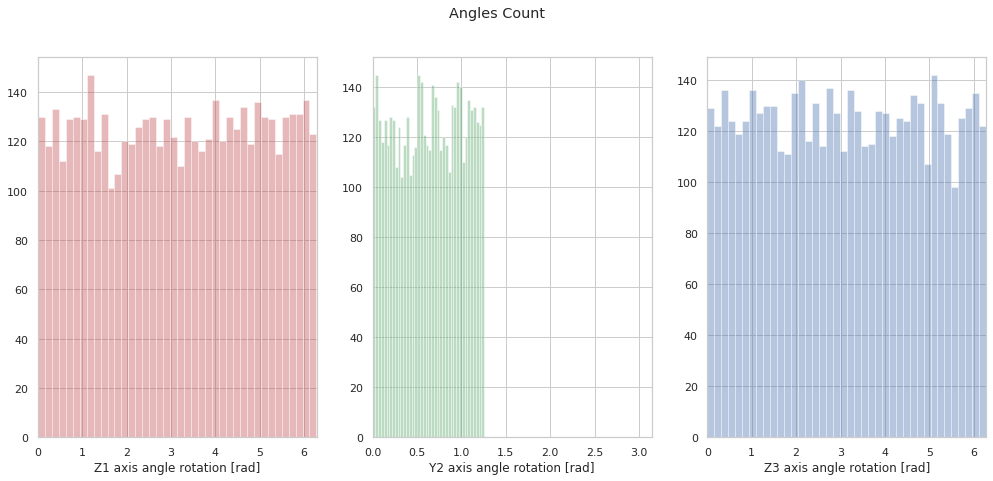

In [94]:
plot_angles_count(angles_true)

---

## Prepare for training

In [8]:
from sklearn.model_selection import train_test_split
from cryoem.distance_estimation import create_pairs

In [9]:
X, y = np.array(data['Projections'], dtype=np.float32), np.array(data['Angles'], dtype=np.float32)

In [10]:
X_max_px = np.max(X)
X = X/X_max_px
print(f"Projection images will be normalized to have pixels ranging from 0 to 1 instead of 1 to {X_max_px}")

Projection images will be normalized to have pixels ranging from 0 to 1 instead of 1 to 15.457941055297852


In [12]:
# the data, split between train and test sets
train_idx, test_idx = train_test_split(range(NUM_PROJECTIONS), 
                                       test_size=0.33, 
                                       random_state=42)
train_idx, val_idx= train_test_split(train_idx, 
                                     test_size=0.25, 
                                     random_state=1)

train_idx = sorted(train_idx)
val_idx = sorted(val_idx)
test_idx = sorted(test_idx)

np.savez("data/5j0n/5j0n_siamese_idx", train_idx, val_idx, test_idx)

In [72]:
np.save("data/5j0n/test_idx", test_idx)

In [11]:
data = np.load("data/5j0n/5j0n_siamese_idx.npz")
#print(data.files)
train_idx, val_idx, test_idx = data["arr_0"], data["arr_1"], data["arr_2"]

In [12]:
# TODO: 2 problems, bigger image now it is 275 instead of 116
# and the tr_pairs bellow the number is a lot decreased

In [13]:
# TODO: increase these values, it is just important to have the batches small enough
tr_pairs, tr_y = create_pairs(X, y, indices=train_idx, num_pairs=80000)
tr_pairs = tr_pairs.reshape(list(tr_pairs.shape) + [-1])
tr_y = tf.cast(tr_y, dtype=tf.float32)

val_pairs, val_y = create_pairs(X, y, indices=val_idx, num_pairs=20000)
val_pairs = val_pairs.reshape(list(val_pairs.shape) + [-1])
val_y = tf.cast(val_y, dtype=tf.float32)

te_pairs, te_y = create_pairs(X, y, indices=test_idx, num_pairs=20000)
te_pairs = te_pairs.reshape(list(te_pairs.shape) + [-1])
te_y = tf.cast(te_y, dtype=tf.float32)

# 1. Distance Estimation

### Train the model

In [ ]:
model, history = train_siamese(training_pairs=tr_pairs, 
              training_y=tr_y, 
              validation_pairs=val_pairs, 
              validation_y=val_y, 
              epochs=500, 
              batch_size=256, 
              learning_rate=0.001,  #0.001 
              plot=True)

Input images shape (116, 116, 1)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 256)          184576      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0     

Epoch 25/500
79872/80000 [============================>.] - ETA: 0s - loss: 0.1593 - mse: 0.0447
Epoch 00025: saving model to training/20200418_032540
80000/80000 [==============================] - 113s 1ms/sample - loss: 0.1593 - mse: 0.0447 - val_loss: 0.1775 - val_mse: 0.0535
Epoch 26/500
79872/80000 [============================>.] - ETA: 0s - loss: 0.1608 - mse: 0.0452
Epoch 00026: saving model to training/20200418_032540
80000/80000 [==============================] - 113s 1ms/sample - loss: 0.1608 - mse: 0.0452 - val_loss: 0.1792 - val_mse: 0.0559
Epoch 27/500
79872/80000 [============================>.] - ETA: 0s - loss: 0.1583 - mse: 0.0441
Epoch 00027: saving model to training/20200418_032540
80000/80000 [==============================] - 114s 1ms/sample - loss: 0.1583 - mse: 0.0442 - val_loss: 0.1764 - val_mse: 0.0499
Epoch 28/500
79872/80000 [============================>.] - ETA: 0s - loss: 0.1574 - mse: 0.0437
Epoch 00028: saving model to training/20200418_032540
80000/800

79872/80000 [============================>.] - ETA: 0s - loss: 0.1495 - mse: 0.0408
Epoch 00083: saving model to training/20200418_032540
80000/80000 [==============================] - 112s 1ms/sample - loss: 0.1495 - mse: 0.0408 - val_loss: 0.1785 - val_mse: 0.0560
Epoch 84/500
79872/80000 [============================>.] - ETA: 0s - loss: 0.1488 - mse: 0.0405
Epoch 00084: saving model to training/20200418_032540
80000/80000 [==============================] - 112s 1ms/sample - loss: 0.1487 - mse: 0.0404 - val_loss: 0.1792 - val_mse: 0.0574
Epoch 85/500
79872/80000 [============================>.] - ETA: 0s - loss: 0.1484 - mse: 0.0405
Epoch 00085: saving model to training/20200418_032540
80000/80000 [==============================] - 112s 1ms/sample - loss: 0.1484 - mse: 0.0405 - val_loss: 0.1742 - val_mse: 0.0501
Epoch 86/500
79872/80000 [============================>.] - ETA: 0s - loss: 0.1489 - mse: 0.0405
Epoch 00086: saving model to training/20200418_032540
80000/80000 [=========

79872/80000 [============================>.] - ETA: 0s - loss: 0.1457 - mse: 0.0396
Epoch 00141: saving model to training/20200418_032540
80000/80000 [==============================] - 112s 1ms/sample - loss: 0.1457 - mse: 0.0396 - val_loss: 0.1744 - val_mse: 0.0546
Epoch 142/500
79872/80000 [============================>.] - ETA: 0s - loss: 0.1454 - mse: 0.0394
Epoch 00142: saving model to training/20200418_032540
80000/80000 [==============================] - 112s 1ms/sample - loss: 0.1454 - mse: 0.0394 - val_loss: 0.1745 - val_mse: 0.0538
Epoch 143/500
79872/80000 [============================>.] - ETA: 0s - loss: 0.1457 - mse: 0.0395
Epoch 00143: saving model to training/20200418_032540
80000/80000 [==============================] - 112s 1ms/sample - loss: 0.1457 - mse: 0.0395 - val_loss: 0.1747 - val_mse: 0.0532
Epoch 144/500
79872/80000 [============================>.] - ETA: 0s - loss: 0.1453 - mse: 0.0392
Epoch 00144: saving model to training/20200418_032540
80000/80000 [======

79872/80000 [============================>.] - ETA: 0s - loss: 0.1439 - mse: 0.0388
Epoch 00199: saving model to training/20200418_032540
80000/80000 [==============================] - 112s 1ms/sample - loss: 0.1439 - mse: 0.0388 - val_loss: 0.1734 - val_mse: 0.0515
Epoch 200/500
79872/80000 [============================>.] - ETA: 0s - loss: 0.1439 - mse: 0.0389
Epoch 00200: saving model to training/20200418_032540
80000/80000 [==============================] - 112s 1ms/sample - loss: 0.1439 - mse: 0.0389 - val_loss: 0.1727 - val_mse: 0.0518
Epoch 201/500
79872/80000 [============================>.] - ETA: 0s - loss: 0.1443 - mse: 0.0389
Epoch 00201: saving model to training/20200418_032540
80000/80000 [==============================] - 112s 1ms/sample - loss: 0.1442 - mse: 0.0389 - val_loss: 0.1788 - val_mse: 0.0553
Epoch 202/500
79872/80000 [============================>.] - ETA: 0s - loss: 0.1440 - mse: 0.0389
Epoch 00202: saving model to training/20200418_032540
80000/80000 [======

79872/80000 [============================>.] - ETA: 0s - loss: 0.1427 - mse: 0.0386
Epoch 00257: saving model to training/20200418_032540
80000/80000 [==============================] - 112s 1ms/sample - loss: 0.1428 - mse: 0.0386 - val_loss: 0.1833 - val_mse: 0.0605
Epoch 258/500
79872/80000 [============================>.] - ETA: 0s - loss: 0.1430 - mse: 0.0387
Epoch 00258: saving model to training/20200418_032540
80000/80000 [==============================] - 112s 1ms/sample - loss: 0.1430 - mse: 0.0387 - val_loss: 0.1745 - val_mse: 0.0518
Epoch 259/500
 4864/80000 [>.............................] - ETA: 1:36 - loss: 0.1388 - mse: 0.0376

In [ ]:
training_loss = history.history['loss']
val_loss = history.history['val_loss']
mses = history.history['mse']
val_mses = history.history['val_mse']

np.savez("data/5j0n/5j0n_DE_history", training_loss, val_loss, mses, val_mses)

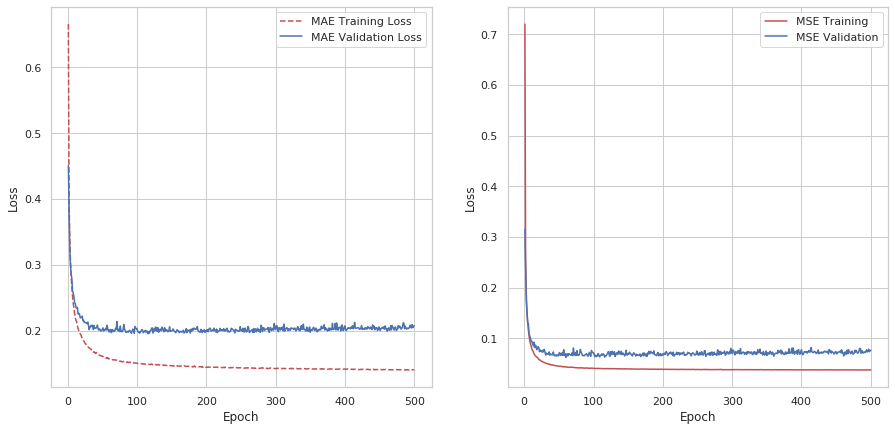

In [22]:
# Get training and test loss histories
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
ax1.plot(epoch_count, training_loss, 'r--', label='MAE Training Loss')
ax1.plot(epoch_count, val_loss, 'b-', label='MAE Validation Loss')
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2.plot(epoch_count, mses, 'r-', label='MSE Training')
ax2.plot(epoch_count, val_mses, 'b-', label='MSE Validation')
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
plt.show();

### (Or) Read model checkpoint

In [13]:
# stop here, change file

In [14]:
# #model_filename = "training/20191218_023743.h5"

# On LTS: "training/20200221_061000.h5"
# model_filename = "training/20200220_055622.h5" local, MSE as loss, 60K training
#model_filename = "training/20200305_055207.h5" # local, MAE as loss, 60K training
#model_filename = "training/20200416_094914.h5"
#model_filename = "training/20200417_192953.h5"
model_filename = "training/20200418_190002.h5"
#model_filename = "training/20200418_190118.h5" for symmetric

In [15]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 256)          184576      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

### Some model results

In [16]:
from cryoem.distance_estimation import plot_results

In [17]:
y_tr_pred = model.predict_on_batch([tr_pairs[:256, 0], tr_pairs[:256, 1]])
y_val_pred = model.predict_on_batch([val_pairs[:256, 0], val_pairs[:256, 1]])

In [18]:
plot_train_results = plot_results(tr_pairs, y_tr_pred, tr_y, "Train")
plot_validation_results = plot_results(val_pairs, y_val_pred, val_y, "Validation")

--- Train Set ---
predicted: 0.46685823798179626
true:      0.4878542423248291
mse:       0.00044083219836466014
mae:       0.020996004343032837


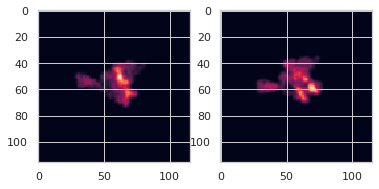

In [19]:
plot_train_results(1)

--- Validation Set ---
predicted: 2.2415599822998047
true:      2.3090646266937256
mse:       0.004556877072900534
mae:       0.0675046443939209


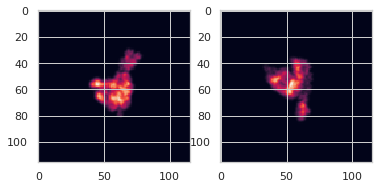

In [20]:
plot_validation_results(0)

---

## dP/dQ plot

In [21]:
from cryoem.conversions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ,plot_dP_dQ_density

In [22]:
def d_p(p1, p2):
    dist = []
    p1 = tf.cast(p1, dtype=tf.float64)
    p2 = tf.cast(p2, dtype=tf.float64)

    for i in np.arange(0, len(p1), 256):
        _p1 = p1[i:i+256, :, :]
        _p2 = p2[i:i+256, :, :]
        
        _p1 = tf.convert_to_tensor(_p1)
        _p1 = tf.expand_dims(_p1, len(_p1.shape)) 
        _p2 = tf.convert_to_tensor(_p2)
        _p2 = tf.expand_dims(_p2, len(_p2.shape))   #p2 = p2.reshape(list(p2.shape) + [-1]) 

        d = model.predict_on_batch([_p1, _p2])
        d = tf.cast(d, dtype=tf.float64)
        dist.append(d)
    
    dist = tf.concat(dist, axis=0)

    return dist

In [23]:
idx1 = list(np.random.choice(test_idx, size=1000))
idx2 = list(np.random.choice(test_idx, size=1000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

p1 = [X[i] for i in idx1]
p2 = [X[i] for i in idx2]

dP_values = d_p(p1, p2).numpy().T[0]
dQ_values = d_q(q1_true, q2_true).numpy()

In [40]:
np.savez("data/5j0n/5j0n_DE_dPdQ_plot", dP_values, dQ_values)

<Figure size 432x288 with 0 Axes>

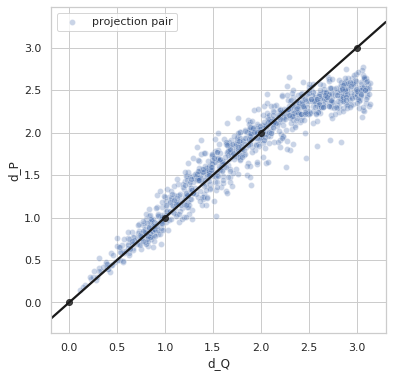

In [24]:
plot_dP_dQ(dP_values, dQ_values)

<Figure size 432x288 with 0 Axes>

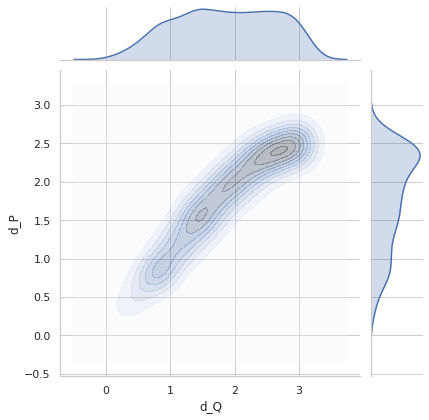

In [25]:
plot_dP_dQ_density(dP_values, dQ_values)

In [26]:
def loss(dQ_values, dP_values):
    # The mean doesn't depend on the batch size.
    return tf.reduce_mean(tf.pow((dQ_values - dP_values), 2))

In [27]:
loss(dQ_values, dP_values).numpy()

0.0650338732523186

In [28]:
np.sqrt(1/(len(dQ_values)-1)*np.sum(np.power(dP_values-dQ_values, 2)))

0.2551450023507087

# 2. Angle Recovery

## Angle Recovery

Perfect distances. Learning rate 0.01

In [29]:
from cryoem.angle_recovery import train_angle_recovery, angles_transpose

In [30]:
X = tf.cast(X, dtype=tf.float64)
X = X.numpy()

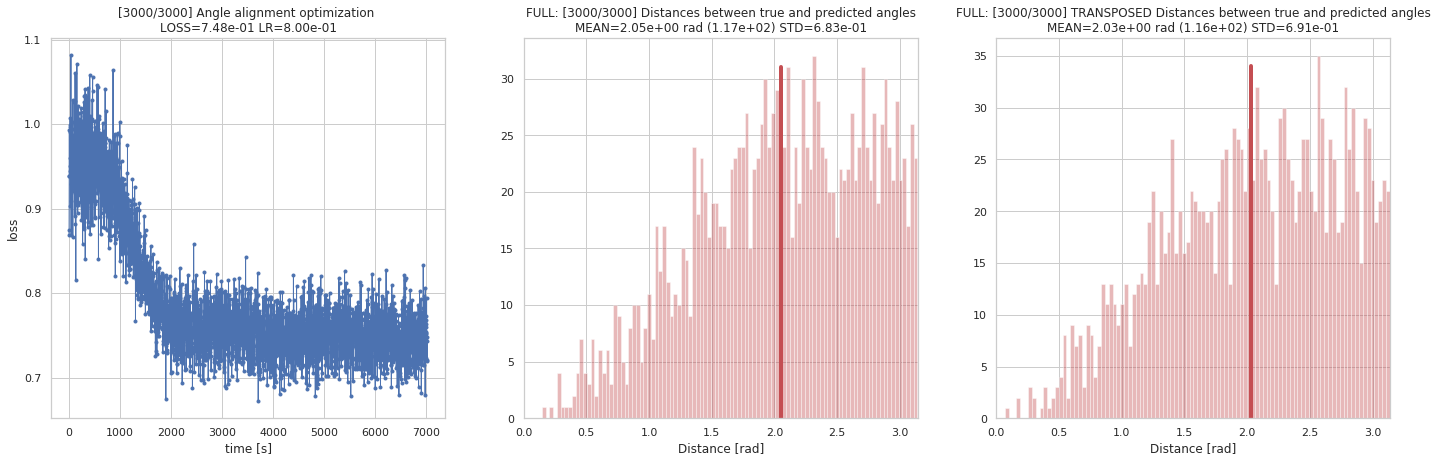

Shape of projections: (1650, 116, 116)step 300/3000 (712s): loss = 9.31e-01
step 600/3000 (1409s): loss = 8.32e-01
step 900/3000 (2108s): loss = 7.77e-01
step 1200/3000 (2807s): loss = 7.51e-01
step 1500/3000 (3507s): loss = 7.92e-01
step 1800/3000 (4207s): loss = 7.80e-01
step 2100/3000 (4908s): loss = 8.00e-01
step 2400/3000 (5610s): loss = 7.22e-01
step 2700/3000 (6312s): loss = 7.15e-01
step 3000/3000 (7015s): loss = 7.21e-01



In [33]:
q_predicted2, losses2, arr2 = train_angle_recovery(steps=3000, 
                                                   batch_size=512, 
                                                   in_data=X[test_idx], 
                                                   distance_fn=d_p, 
                                                   learning_rate=0.8, #0.1, 
                                                   angles_true=angles_true[test_idx],
                                                   optimization=True)

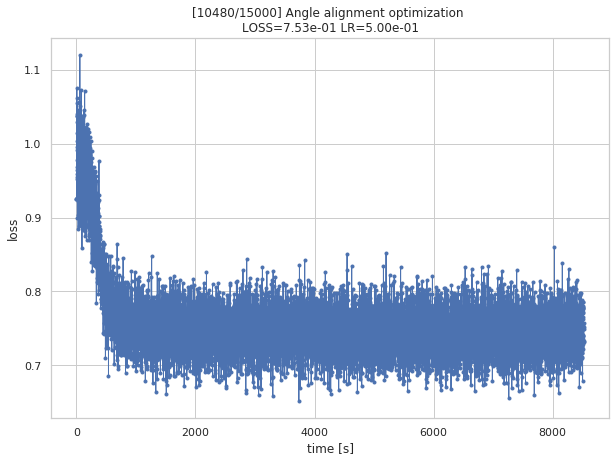

step 1500/15000 (1226s): loss = 7.61e-01
step 3000/15000 (2441s): loss = 7.71e-01
step 4500/15000 (3654s): loss = 7.33e-01
step 6000/15000 (4868s): loss = 7.34e-01
step 7500/15000 (6086s): loss = 7.21e-01
step 9000/15000 (7313s): loss = 7.46e-01



In [71]:
# train_angle_recovery(steps=300000, 
#                      batch_size=256, 
#                      projection_idx=test_idx, 
#                      angles_predicted=angles_predicted, 
#                      est_dist_input=X, 
#                      est_dist=d_p, 
#                      learning_rate=0.01, 
#                      optimization=True)
q_predicted, losses, arr = train_angle_recovery(steps=15000, 
                                  batch_size=512, 
                                 projection_idx=test_idx, 
                                 in_data=X, 
                                 distance_fn=d_p, 
                                 learning_rate=0.5, #0.1, 
                                 optimization=True)

# TODO: from quat

In [95]:
from scipy.spatial.transform import Rotation as R

arr_true = R.from_euler('zyz', angles_true).as_rotvec()
a = arr_true[test_idx]
b = arr2.copy() #arr2[:, test_idx, :]
print(b.shape)

ipv.figure()
s = ipv.scatter(b[:, :,0], b[:, :,1], b[:, :,2], marker="sphere", color="blue", size=1)
ipv.scatter(a[:,0], a[:,1], a[:,2], marker="sphere", color="red", size=1)
ipv.xlim(-np.pi, np.pi);ipv.ylim(-np.pi, np.pi);ipv.zlim(-np.pi, np.pi);
ipv.animation_control(s, interval=50)
ipv.show()

(300, 1650, 3)


In [36]:
np.save("data/5j0n/predicted_quaternions_siamese_losses_ar2.npy", losses2)

In [37]:
np.save("data/5j0n/predicted_quaternions_siamese_arr_ar2.npy", arr2)

In [74]:
q_save = np.zeros((len(q_predicted2),4))
for i, q in enumerate(q_predicted2):
    q_save[i] = q.numpy()
#q_save = q_save[test_idx]                 
np.save("data/5j0n/predicted_quaternions_siamese2.npy", q_save)

## Angle Alignment

In [75]:
from cryoem.conversions import quaternion2euler
import seaborn as sns; sns.set(style="white", color_codes=True)

In [76]:
qp = np.load("data/5j0n/predicted_quaternions_siamese2.npy")

#transposed = False
ap = quaternion2euler(qp).numpy()
#ap = angles_transpose(ap)

np.save("data/5j0n/predicted_angles_siamese2.npy", ap)

In [77]:
qp_test = qp.copy() #qp[test_idx]
at_test = angles_true[test_idx]
ap_test = ap.copy() #ap[test_idx]

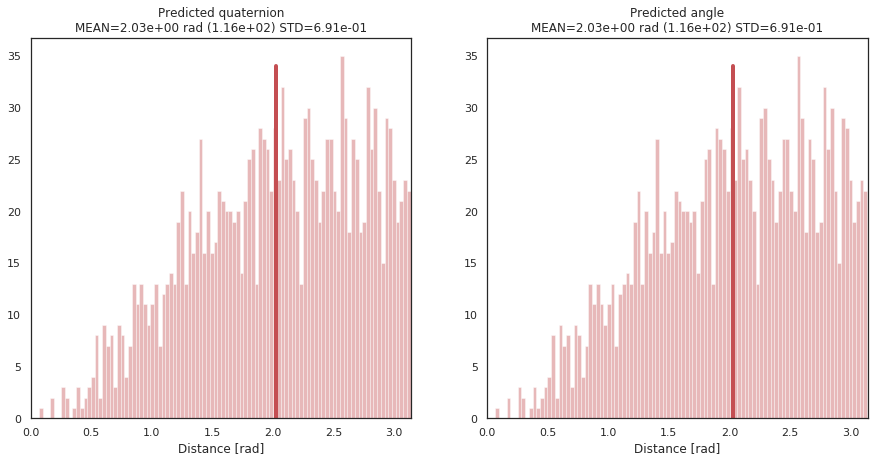

In [78]:
# check: both plots should be the same (if transposed=False)
fig, axs = plt.subplots(1, 2, figsize=(15,7))
d2 = d_q(euler2quaternion(at_test), qp_test)
axs[0].set_xlim(0, np.pi)
axs[0].set_title(f"Predicted quaternion\nMEAN={np.mean(d2):.2e} rad ({np.degrees(np.mean(d2)):.2e}) STD={np.std(d2):.2e}")
s = sns.distplot(d2, kde=False, bins=100, ax=axs[0], axlabel="Distance [rad]", color="r")
max_count = int(max([h.get_height() for h in s.patches]))
axs[0].plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

d3 = d_q(euler2quaternion(at_test), euler2quaternion(ap_test))
axs[1].set_xlim(0, np.pi)
axs[1].set_title(f"Predicted angle\nMEAN={np.mean(d3):.2e} rad ({np.degrees(np.mean(d3)):.2e}) STD={np.std(d3):.2e}")
s = sns.distplot(d3, kde=False, bins=100, ax=axs[1], axlabel="Distance [rad]", color="r")
max_count = int(max([h.get_height() for h in s.patches]))
axs[1].plot([np.mean(d3)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

In [87]:
from cryoem.angle_alignment import training_angle_alignment, update_quaternion

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
from cryoem.conversions import euler2quaternion, d_q, quaternion2euler
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow_graphics.geometry.transformation import quaternion
from time import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="white", color_codes=True)
import random
from tensorflow_graphics.math import vector
from itertools import product
from cryoem.rotation_matrices import euler2matrix, d_r
import time
from IPython import display as IPyDisplay
from scipy.spatial.transform import Rotation as R


def euler6tomarix4d(a_R):

    xy, xz, xw, yz, yw, zw = tf.unstack(a_R, axis=-1)
    
    cxy = tf.cos(xy)
    cxz = tf.cos(xz)
    cxw = tf.cos(xw)
    cyz = tf.cos(yz)
    cyw = tf.cos(yw)
    czw = tf.cos(zw)
    
    sxy = tf.sin(xy)
    sxz = tf.sin(xz)
    sxw = tf.sin(xw)
    syz = tf.sin(yz)
    syw = tf.sin(yw)
    szw = tf.sin(zw)
    
    # Note: wasn't able to create it as simple as np.ndarrays...
    Rxy = [[  cxy,  -sxy, [0.0], [0.0]], 
           [  sxy,   cxy, [0.0], [0.0]],
           [[0.0], [0.0], [1.0], [0.0]],
           [[0.0], [0.0], [0.0], [1.0]]]
    Rxy = tf.reshape(tf.convert_to_tensor(Rxy, dtype=tf.float64), (4, 4)) 
    
    Rxz = [[  cxz, [0.0],  -sxz, [0.0]],
           [[0.0], [1.0], [0.0], [0.0]],
           [  sxz, [0.0],   cxz, [0.0]],
           [[0.0], [0.0], [0.0], [1.0]]]
    Rxz = tf.reshape(tf.convert_to_tensor(Rxz, dtype=tf.float64), (4, 4))
    
    Rxw = [[  cxw, [0.0], [0.0],  -sxw],
           [[0.0], [1.0], [0.0], [0.0]],
           [[0.0], [0.0], [1.0], [0.0]], 
           [  sxw, [0.0], [0.0],  cxw]]
    Rxw = tf.reshape(tf.convert_to_tensor(Rxw, dtype=tf.float64), (4, 4))
    
    Ryz = [[[1.0], [0.0], [0.0], [0.0]],
           [[0.0],   cyz,  -syz, [0.0]],
           [[0.0],   syz,   cyz, [0.0]],
           [[0.0], [0.0], [0.0], [1.0]]]
    Ryz = tf.reshape(tf.convert_to_tensor(Ryz, dtype=tf.float64), (4, 4))
    
    Ryw = [[[1.0], [0.0], [0.0], [0.0]],
           [[0.0],   cyw, [0.0],  -syw],
           [[0.0], [0.0], [1.0], [0.0]],
           [[0.0],   syw, [0.0],  cyw]]
    Ryw = tf.reshape(tf.convert_to_tensor(Ryw, dtype=tf.float64), (4, 4))
    
    Rzw = [[[1.0], [0.0], [0.0], [0.0]],
           [[0.0], [1.0], [0.0], [0.0]], 
           [[0.0], [0.0],   czw,  -szw],
           [[0.0], [0.0],   szw,  czw]]
    Rzw = tf.reshape(tf.convert_to_tensor(Rzw, dtype=tf.float64), (4, 4))
  
    R = Rxy @ Rxz @ Rxw @ Ryz @ Ryw @ Rzw

    # check if matrix is orthogonal: R^T @ R - I < 1e-5
    assert tf.reduce_all(tf.less_equal(tf.abs(tf.subtract(tf.transpose(R) @ R, tf.eye(4, 4, dtype=tf.float64))), 1e-5)), "Matrix R (4x4) should be orthogonal!" 
        
    return R


def update_quaternion(m, a_R, q_predicted):
    # 4D matrix rotation
    R = euler6tomarix4d(a_R)
    I = tf.linalg.diag(tf.convert_to_tensor(m, dtype=tf.float64))
    q_predicted_rotated = tf.transpose(R @ I @ tf.transpose(q_predicted))

    return q_predicted_rotated

def loss_alignment(m, a_R, q_predicted, q_true):
    # 4D matrix rotation
    R = euler6tomarix4d(a_R)
    I = tf.linalg.diag(tf.convert_to_tensor(m, dtype=tf.float64))
    q_predicted_rotated = tf.transpose(R @ I @ tf.transpose(q_predicted))

    return tf.reduce_mean(d_q(q_true, q_predicted_rotated))


def gradient_alignment(m, a_R, q_predicted, q_true):
    with tf.GradientTape() as tape:
        loss_value = loss_alignment(m, a_R, q_predicted, q_true)
        gradient = tape.gradient(loss_value, a_R)
        
    return loss_value, gradient


def training_angle_alignment(m, steps, batch_size, learning_rate, angles_true, angles_predicted):
    
    with tf.device('/device:GPU:0'):
        arr = []
        
        optimizer = Adam(learning_rate=learning_rate)
        
        time_start = time.time()

        report = ""

        losses = np.empty(steps)
        angles_predicted = tf.convert_to_tensor(angles_predicted)

        euler = tf.random.uniform([6], 0, 2*np.pi, dtype=tf.float64) #np.zeros(6, dtype=np.float64)
        a_R = [tf.Variable(euler)]
        
        q_predicted = euler2quaternion(angles_predicted)
        q_true = euler2quaternion(angles_true)

        for step in range(1, steps+1):

            # Sample some pairs.
            idx = list(np.random.choice(range(len(angles_predicted)), size=batch_size))

            # Compute distances between projections
            qt = [q_true[i]      for i in idx]
            qp = [q_predicted[i] for i in idx]

            # Optimize by gradient descent.
            losses[step-1], gradients = gradient_alignment(m, a_R, qp, qt)
            optimizer.apply_gradients(zip(gradients, a_R))
            
            update_lr = 300
            if step>update_lr and step%update_lr==0 and losses[step-1]-losses[step-1-update_lr+100] < 0.1:
                learning_rate *= 0.1

            # Visualize progress periodically
            if step % 10 == 0:
                qu = update_quaternion(m, a_R, q_predicted)
                
                arr.append(R.from_quat(update_quaternion(m, a_R, q_predicted)).as_rotvec())
                
                plt.close();
                sns.set(style="white", color_codes=True)
                sns.set(style="whitegrid")

                fig, axs = plt.subplots(1, 3, figsize=(24,7))
                
                # Distance count subplot (batches)
                qpr = update_quaternion(m, a_R, qp)
                d1 = d_q(qpr, qt)
                axs[0].set_xlim(0, np.pi)
                #axs[0].set_ylim(0, batch_size)
                axs[0].set_title(f"BATCHES (size={len(qp)}): [{step}/{steps}] Distances between true and predicted angles \nMEAN={np.mean(d1):.2e} STD={np.std(d1):.2e}")
                s = sns.distplot(d1, kde=False, bins=100, ax=axs[0], axlabel="Distance [rad]", color="r")
                max_count = int(max([h.get_height() for h in s.patches]))
                axs[0].plot([np.mean(d1)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

                # Optimization loss subplot
                axs[1].plot(np.linspace(0, time.time()-time_start, step), losses[:step], marker="o", lw=1, markersize=3)
                axs[1].set_xlabel('time [s]')
                axs[1].set_ylabel('loss');
                axs[1].set_title(f"Angle alignment optimization \nLOSS={np.mean(losses[step-10:step]):.2e} LR={learning_rate:.2e}")
                
                # Distance count subplot (full)
                q_predicted_rot = update_quaternion(m, a_R, q_predicted)
                d2 = d_q(q_predicted_rot, q_true)
                axs[2].set_xlim(0, np.pi)
                # axs[2].set_ylim(0, len(angles_true))
                axs[2].set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
                s = sns.distplot(d2, kde=False, bins=100, ax=axs[2], axlabel="Distance [rad]", color="r")
                max_count = int(max([h.get_height() for h in s.patches]))
                axs[2].plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

                
                IPyDisplay.clear_output(wait=True)
                IPyDisplay.display(plt.gcf())
                plt.close();
                time.sleep(1.0)
        

            # Periodically report progress.
            if ((step % (steps//10)) == 0) or (step == steps):
                time_elapsed = time.time() - time_start
                report += f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {np.mean(losses[step-steps//10:step-1]):.2e}\n'

            if step >= 101 and np.mean(losses[step-101:step-1]) < 1e-3:
                break;

        print(report)
        return m, a_R, losses, np.array(arr)

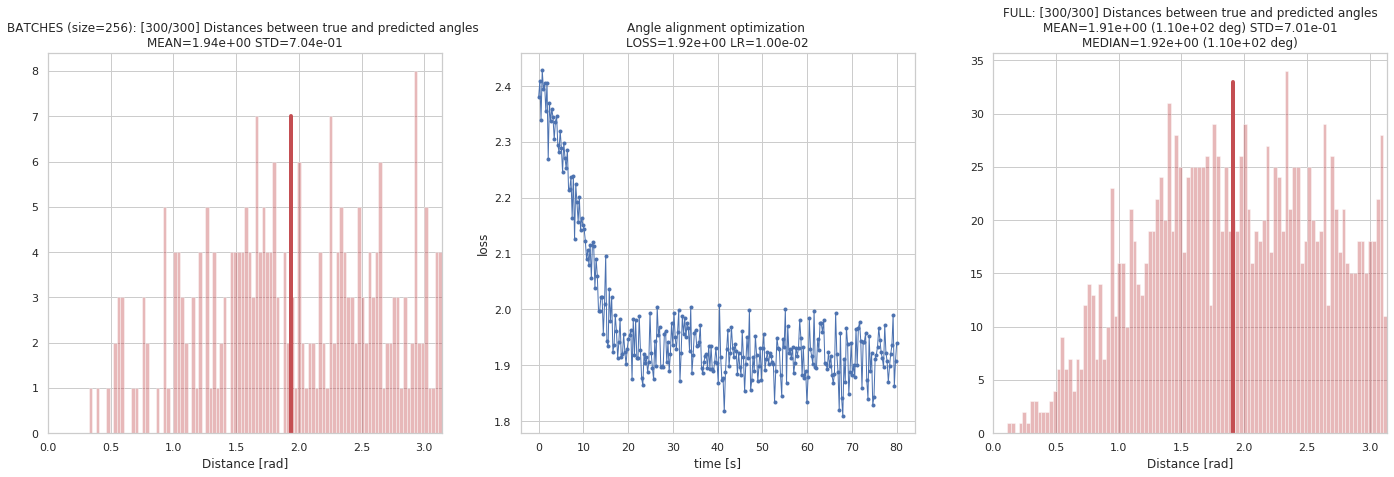

step 30/300 (8s): loss = 2.32e+00
step 60/300 (16s): loss = 2.09e+00
step 90/300 (25s): loss = 1.94e+00
step 120/300 (33s): loss = 1.93e+00
step 150/300 (41s): loss = 1.93e+00
step 180/300 (49s): loss = 1.91e+00
step 210/300 (57s): loss = 1.91e+00
step 240/300 (66s): loss = 1.93e+00
step 270/300 (74s): loss = 1.90e+00
step 300/300 (82s): loss = 1.91e+00



In [91]:
m, rotation, loss, arr_aa = training_angle_alignment(m=[1.0, 1.0, 1.0, 1.0],
                                             steps=300, 
                                             batch_size=256,  
                                             learning_rate=0.01, 
                                             angles_true=angles_true[test_idx], 
                                             angles_predicted=ap)

In [92]:
m, rotation[0].numpy(), loss[-1]

([1.0, 1.0, 1.0, 1.0],
 array([4.06229592, 3.19459292, 5.80746796, 5.93206813, 2.64329271,
        4.62564705]),
 1.9399684617821265)

In [93]:
from scipy.spatial.transform import Rotation as R

arr_true = R.from_euler('zyz', angles_true).as_rotvec()
a = arr_true[test_idx]
b = arr_aa.copy() #arr_aa[:, test_idx, :]
print(b.shape)

ipv.figure()
s = ipv.scatter(b[:, :,0], b[:, :,1], b[:, :,2], marker="sphere", color="blue", size=1)
ipv.scatter(a[:,0], a[:,1], a[:,2], marker="sphere", color="red", size=1)
ipv.animation_control(s, interval=200)
ipv.show()

(30, 1650, 3)


In [86]:
from scipy.spatial.transform import Rotation as R

arr2 = R.from_euler('zyz', angles_true).as_rotvec()

ipv.figure()
s = ipv.scatter(arr_aa[:, :,0], arr_aa[:, :,1], arr_aa[:, :,2], marker="sphere", color="blue", size=1)
ipv.scatter(arr2[:,0], arr2[:,1], arr2[:,2], marker="sphere", color="red", size=1)
ipv.animation_control(s, interval=200)
ipv.show()

In [71]:
qpn = euler2quaternion(ap)

qpa = update_quaternion(m=m, 
                        a_R=rotation, 
                        q_predicted=qpn)

angles_predicted = quaternion2euler(qpa).numpy()

np.save("data/5a1a/predicted_angles_siamese_updated2.npy", angles_predicted)

In [108]:
# Image(filename='../3-reconstruction/data/5a1a_projections_and_angles_predicted_updated.png')

---